# Autores
- Jhon Alejandro Jaramillo Echeverri
- Juan Sebastián Salazar Luna

## **Objetivo a desarrollar:**

Estos dataset, fueron extraidos del SIMEM (llamados: ReservasHidraulicasEnergía.xlsx y VertimientosHidricos.xlsx). Los cuales seran usados para la predicción de un modelo de clasificación, indicando si hay vertimientos (1) o no (0) en los embalses.

## **Conjuntos de datos**:

- ### SIMEM (Sistema de Información para el Mercado de Energía Mayorista):

    ##### **Descripción**:

   El SIMEM es el Sistema de Información del Mercado de Energía Mayorista creado por la resolución CREG 101 018 de 2022, es un portal de datos abiertos que facilita el acceso y unifica las variables del mercado mayorista en único sitio para el apoyo de toma de decisiones promoviendo la competencia la eficiencia, la transparencia y el libre acceso a la información cierta, suficiente, clara y oportuna.

| Campo                | Tipo de Dato | Descripción                                                                 |
|----------------------|--------------|-----------------------------------------------------------------------------|
| codigo_embalse       | Texto        | Código único que identifica cada embalse.                                  |
| region               | Texto        | Región de Colombia donde se encuentra el embalse (ej. Antioquia, Valle, etc.). |
| volumen_util         | Numérico     | Volumen útil de agua en el embalse (en m³ u otra unidad).                  |
| capacidad_util       | Numérico     | Capacidad útil máxima del embalse (en m³ u otra unidad).                   |
| volumen_total        | Numérico     | Volumen total de agua almacenada en el embalse (en m³ u otra unidad).      |
| VertimientosEnergia  | Numérico     | Cantidad de energía generada por vertimientos (posiblemente en MW).        |
| fecha                | Fecha        | Fecha de registro de los datos (formato YYYY-MM-DD).                       |
| vertimientos         | Numérico     | Volumen de agua vertida (en m³ u otra unidad).                             |
| duracion             | Texto        | Duración del período de medición (ej. "P1D" para un día).                  |
| etiqueta             | Numérico     | Etiqueta binaria (0 o 1) que podría indicar eventos especiales (ej. vertimientos). |


- conclusiones
- Referencias

# Preparación del dataset de Vertimientos Hídricos

### 1. librerias que vamos a usar

In [3]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from imblearn.over_sampling import RandomOverSampler
warnings.filterwarnings('ignore')

#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones import multiple_plot

### 2. Carga y Exploración Inicial de Datos

In [5]:
# Cargar los datasets
reservas = pd.read_excel('Data/ReservasHidraulicasEnergía.xlsx')
vertimientos = pd.read_excel('Data/VertimientosHidricos.xlsx')

# Exploración inicial
print("=== Reservas Hidrológicas ===")
print(reservas.info())
print("\nPrimeras filas:\n", reservas.head())

print("\n=== Vertimientos Hidrológicos ===")
print(vertimientos.info())
print("\nPrimeras filas:\n", vertimientos.head())

=== Reservas Hidrológicas ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106472 entries, 0 to 106471
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   FechaPublicacion          106472 non-null  object 
 1   Fecha                     106472 non-null  object 
 2   CodigoEmbalse             106472 non-null  object 
 3   RegionHidrologica         106472 non-null  object 
 4   VolumenUtilDiarioEnergia  106472 non-null  int64  
 5   CapacidadUtilEnergia      106472 non-null  int64  
 6   VolumenTotalEnergia       106472 non-null  int64  
 7   VertimientosEnergia       106472 non-null  float64
 8   Total                     0 non-null       float64
dtypes: float64(2), int64(3), object(4)
memory usage: 7.3+ MB
None

Primeras filas:
   FechaPublicacion       Fecha CodigoEmbalse RegionHidrologica  \
0       2023-12-19  2013-01-31  AGREGADO_SIN          Colombia   
1       2023-12-19  2013-01

# 3. Limpieza y Preparación de Datos

### Para el dataset de Reservas:

In [6]:
# Renombrar columnas para consistencia
reservas = reservas.rename(columns={
    'CodigoEmbalse': 'codigo_embalse',
    'RegionHidrologica': 'region',
    'VolumenUtilDiarioEnergia': 'volumen_util',
    'CapacidadUtilEnergia': 'capacidad_util',
    'VolumenTotalEnergia': 'volumen_total'
})

# Convertir fecha y eliminar columnas innecesarias
reservas['fecha'] = pd.to_datetime(reservas['Fecha'])
reservas = reservas.drop(['Fecha', 'FechaPublicacion', 'Total'], axis=1)

### Para el dataset de Vertimientos:

In [7]:
# Renombrar columnas
vertimientos = vertimientos.rename(columns={
    'CodigoEmbalse': 'codigo_embalse',
    'VertimientosEnergia': 'vertimientos',
    'CodigoDuracion': 'duracion'
})

# Convertir fecha
vertimientos['fecha'] = pd.to_datetime(vertimientos['Fecha'])
vertimientos = vertimientos.drop('Fecha', axis=1)

# 4. Verificación de Claves para el Merge

In [8]:
# Verificar duplicados en las claves
print("Duplicados en Reservas:", reservas.duplicated(['fecha', 'codigo_embalse']).sum())
print("Duplicados en Vertimientos:", vertimientos.duplicated(['fecha', 'codigo_embalse']).sum())

# Verificar valores únicos
print("\nEmbalses únicos en Reservas:", reservas['codigo_embalse'].nunique())
print("Embalses únicos en Vertimientos:", vertimientos['codigo_embalse'].nunique())

# Verificar solapamiento temporal
print("\nRango de fechas Reservas:", reservas['fecha'].min(), "a", reservas['fecha'].max())
print("Rango de fechas Vertimientos:", vertimientos['fecha'].min(), "a", vertimientos['fecha'].max())

Duplicados en Reservas: 1
Duplicados en Vertimientos: 1

Embalses únicos en Reservas: 26
Embalses únicos en Vertimientos: 27

Rango de fechas Reservas: 2013-01-01 00:00:00 a 2025-03-31 00:00:00
Rango de fechas Vertimientos: 2013-01-01 00:00:00 a 2025-03-31 00:00:00


# 4. Realización del Merge

In [41]:
df_merge = pd.merge(
    reservas,
    vertimientos,
    on=['fecha', 'codigo_embalse'],
    how='left',  # Mantener todos los registros de reservas
    suffixes=('', '_vert')
)

# Rellenar NA en vertimientos
df_merge['vertimientos'] = df_merge['vertimientos'].fillna(0)

### Tomar el 10% de los datos

In [42]:
# Crear etiqueta binaria si no existe
if 'etiqueta' not in df_merge.columns:
	df_merge['etiqueta'] = (df_merge['vertimientos'] > 0).astype(int)

# Porcentaje de datos a tomar
percentage = 0.10

# Número de muestras por clase
n_samples_per_class = int(len(df_merge) * percentage / 2)

# Tomar muestras balanceadas por clase
df_sampled = df_merge.groupby('etiqueta', group_keys=False).apply(lambda x: x.sample(n=n_samples_per_class, random_state=123))

# Verificar balance
print("\nDistribución de etiquetas en la muestra:")
print(df_merge['etiqueta'].value_counts())

df_sampled.info()


Distribución de etiquetas en la muestra:
etiqueta
0    97911
1     8563
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 10646 entries, 58875 to 45187
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   codigo_embalse       10646 non-null  object        
 1   region               10646 non-null  object        
 2   volumen_util         10646 non-null  int64         
 3   capacidad_util       10646 non-null  int64         
 4   volumen_total        10646 non-null  int64         
 5   VertimientosEnergia  10646 non-null  float64       
 6   fecha                10646 non-null  datetime64[ns]
 7   vertimientos         10646 non-null  float64       
 8   duracion             10473 non-null  object        
 9   etiqueta             10646 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 914.9+ KB


In [44]:
# Crear etiqueta binaria
df_sampled['etiqueta'] = (df_sampled['vertimientos'] > 0).astype(int)

# Verificar distribución
print("\nDistribución de etiquetas:")
print(df_sampled['etiqueta'].value_counts(normalize=True))


Distribución de etiquetas:
etiqueta
0    0.5
1    0.5
Name: proportion, dtype: float64


In [45]:
print("\n=== Dataset Final ===")
print(f"Registros totales: {len(df_sampled)}")
print("Estructura:")
print(df_sampled.info())
print("\nMuestra de datos:")
print(df_sampled.sample(5))


=== Dataset Final ===
Registros totales: 10646
Estructura:
<class 'pandas.core.frame.DataFrame'>
Index: 10646 entries, 58875 to 45187
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   codigo_embalse       10646 non-null  object        
 1   region               10646 non-null  object        
 2   volumen_util         10646 non-null  int64         
 3   capacidad_util       10646 non-null  int64         
 4   volumen_total        10646 non-null  int64         
 5   VertimientosEnergia  10646 non-null  float64       
 6   fecha                10646 non-null  datetime64[ns]
 7   vertimientos         10646 non-null  float64       
 8   duracion             10473 non-null  object        
 9   etiqueta             10646 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 914.9+ KB
None

Muestra de datos:
      codigo_embalse     region  volumen_

In [46]:
#Lista de variables categóricas
catCols = df_sampled.select_dtypes(include = ["object", 'category']).columns.tolist()

df_sampled[catCols].head(2)

,codigo_embalse,region,duracion
58875,CHUZA,Oriente,P1D
72612,CALIMA1,Valle,P1D


In [47]:
#Lista de variables numéricas

numCols=df_sampled.select_dtypes(include = ['float64','int32','int64']).columns.tolist()


df_sampled[numCols].head(2)

,volumen_util,capacidad_util,volumen_total,VertimientosEnergia,vertimientos,etiqueta
58875,861226800,980599311,907251400,0.0,0.0,0
72612,192894300,217043726,246825500,0.0,0.0,0


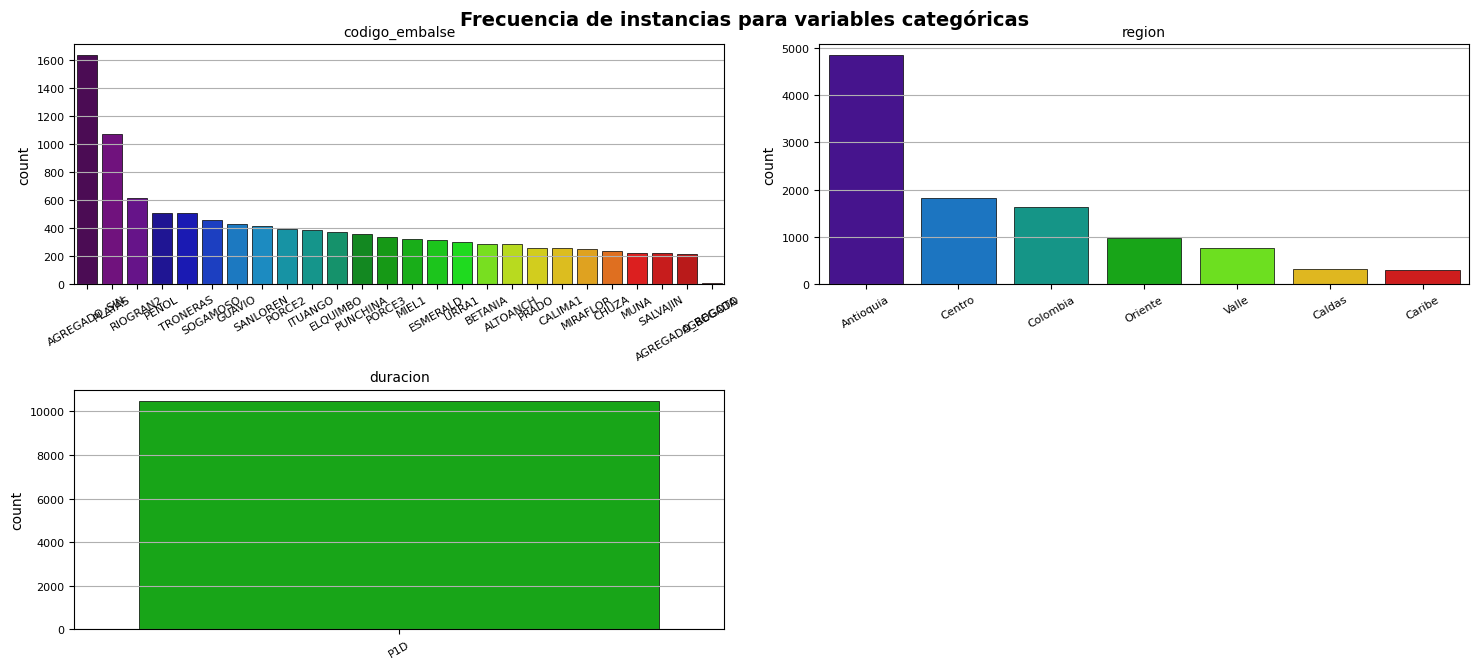

In [48]:
#Visualización de frecuencia de instancias para variables categóricas
multiple_plot(2, df_sampled , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

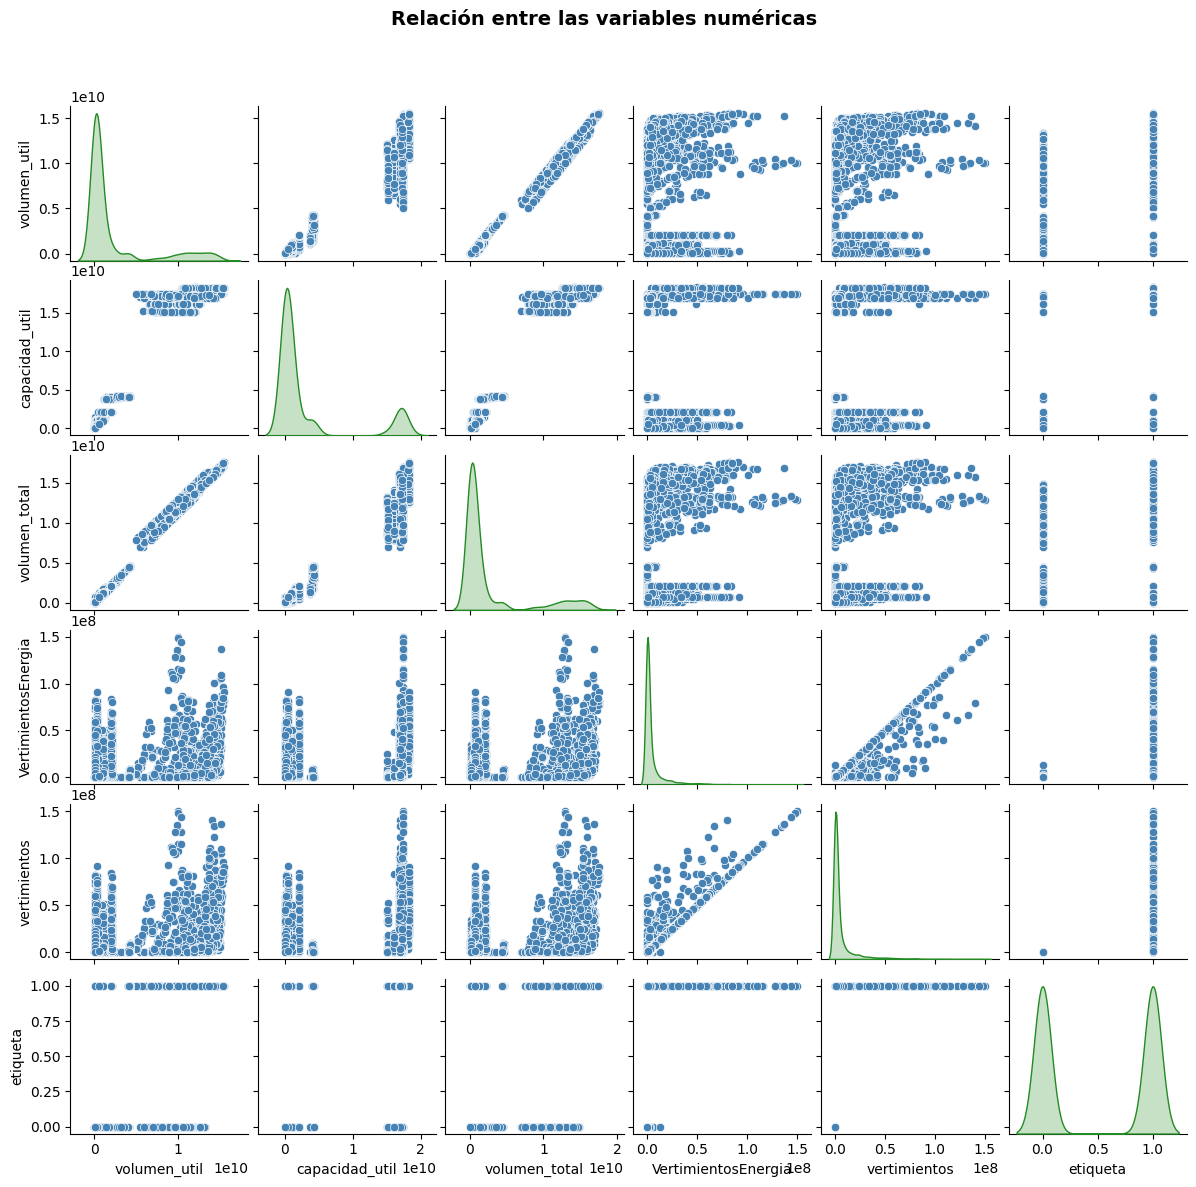

In [49]:
#Visualización de variables numéricas
multiple_plot(1, df_sampled , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [50]:
df_sampled.to_csv('Data/ReservasVertimientos_Merged.csv', index=False)

### Variable de salida

In [51]:
df_sampled.groupby('etiqueta').etiqueta.count().sort_values(ascending=False)

etiqueta
0    5323
1    5323
Name: etiqueta, dtype: int64

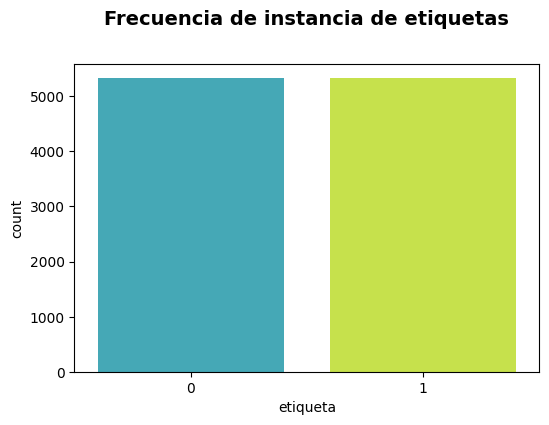

In [52]:
multiple_plot(1, df_sampled, None, 'etiqueta', 'countplot', 'Frecuencia de instancia de etiquetas', 0)

### Datos de prueba

In [53]:
# Porcentaje de filas para la primera parte (por ejemplo, 90%)
percentage_first_part = 0.90

# Número de filas para la primera parte
n_rows_part1 = int(len(df_sampled) * percentage_first_part)

# Obtener índices aleatorios para la primer parte
indices_part1 = df_sampled.sample(n=n_rows_part1, random_state=123).index

# Obtener índices para la segunda parte (resto de las filas)
indices_part2 = df_sampled.index.difference(indices_part1)

# Dividir el DataFrame en dos partes
df = df_sampled.loc[indices_part1]
dp = df_sampled.loc[indices_part2]

### Valores atípicos para las variables de entrada

In [54]:
#utilización de LocalOutlierFactor con 13 vecinos para identificar valores atípicos en las variables de entrada


# crear un objeto LocalOutlierFactor con n_neighbors=13
lof = LocalOutlierFactor(n_neighbors=13, contamination=0.1)

# identificar los valores atípicos por medio de lof
y_pred = lof.fit_predict(df[numCols])

# Identificar los índices de los valores atípicos
outliers = y_pred == -1

print('Indices de valores atípicos: ', df[outliers].index.tolist())

Indices de valores atípicos:  [72183, 102951, 16085, 7512, 85175, 71712, 48870, 34431, 106351, 103414, 83346, 62574, 80963, 12540, 84743, 92447, 43934, 38432, 82971, 29959, 4832, 55513, 72545, 37289, 25208, 40112, 93425, 6007, 56051, 84134, 89420, 45400, 22525, 98712, 88238, 81096, 49530, 51319, 149, 76827, 49124, 1376, 81029, 46491, 85499, 5168, 84473, 76846, 24224, 30418, 105307, 76635, 84771, 46723, 36524, 49364, 50381, 91123, 22492, 39565, 80143, 74474, 91201, 32031, 55597, 72417, 5105, 50038, 87314, 101836, 47788, 93522, 39180, 105966, 72907, 20593, 18777, 28702, 3117, 43565, 68879, 34878, 83870, 930, 81070, 1393, 81649, 11222, 49882, 27827, 31964, 73804, 49821, 97345, 983, 49910, 54187, 48754, 41461, 30054, 27508, 36742, 95552, 21382, 17889, 73169, 74972, 46135, 72821, 32811, 74010, 74561, 84062, 25878, 31978, 72394, 5689, 67021, 85221, 68163, 91782, 55354, 85285, 45791, 93722, 100736, 87827, 50030, 32970, 69994, 85118, 63141, 96151, 84725, 966, 421, 15994, 27393, 48970, 37148, 3

In [55]:
# Eliminar los valores atípicos del dataframe original
df = df.loc[~outliers]

In [56]:
df.shape

(8623, 10)

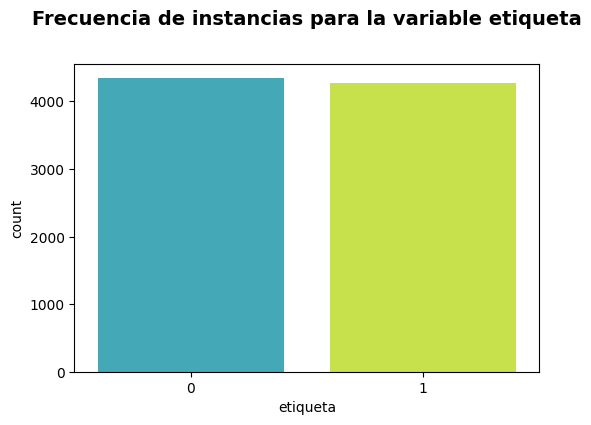

In [57]:
multiple_plot(1, df , None, 'etiqueta', 'countplot', 'Frecuencia de instancias para la variable etiqueta',0)

In [58]:
df.groupby('etiqueta').etiqueta.count().sort_values(ascending=False)

etiqueta
0    4342
1    4281
Name: etiqueta, dtype: int64

### Sobremuestreo (oversampling)

In [59]:
# Se crea un objeto RandomOverSampler que permite crear copias aleatorias de las muestras de la clase
# minoritaria para igualar el número de muestras entre las diferentes clases.
oversampler = RandomOverSampler()

# Se realiza el sobremuestreo para las variables de entrada y salida
X_resampled, y_resampled = oversampler.fit_resample(df.drop('etiqueta', axis=1), df['etiqueta'])

# Se crean dos dataframes con las variables de entrada y otro con la variable de salida a partir del proceso anterior
df1 = pd.DataFrame(X_resampled, columns=df.columns.drop('etiqueta'))
df2 = pd.DataFrame(y_resampled)

# Se concatenan los dataframes horizontalmente
df_balanced = pd.concat([df1, df2], axis=1)

df=df_balanced

In [60]:
df.shape

(8684, 10)

In [61]:
# Dataset balanceado
df.head(2)

,codigo_embalse,region,volumen_util,capacidad_util,volumen_total,VertimientosEnergia,fecha,vertimientos,duracion,etiqueta
0,GUAVIO,Oriente,578235700,2095258858,628685700,0.000000e+00,2014-05-12,0.00,P1D,0
1,SANLOREN,Antioquia,441580700,424496733,485893800,1.134042e+07,2022-08-02,11340415.15,P1D,1


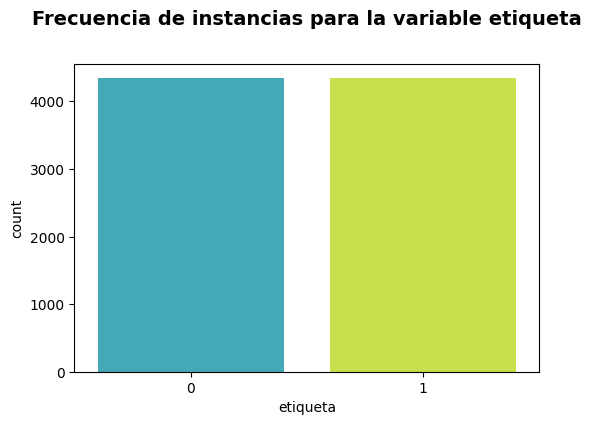

In [62]:
multiple_plot(1, df , None, 'etiqueta', 'countplot', 'Frecuencia de instancias para la variable etiqueta',0)

# Exportar el dataset

In [63]:
# Exportamos el dataframe a un archivo CSV
df.to_csv('./Data/clas_Vertimiento_Prep.csv', index=False)
dp.to_csv('./Data/clas_Vertimiento_Prue.csv', index=False)

### Concluisiones

- Durante la preparación del dataset, se identificaron y trataron valores faltantes, inconsistencias o datos atípicos que podrían haber afectado el rendimiento del modelo de clasificación. Esto asegura que los datos sean más confiables para el análisis.

- Se realizó un análisis de las variables disponibles, eliminando aquellas que no aportaban información relevante o que estaban altamente correlacionadas con otras. Esto ayuda a reducir la dimensionalidad y mejora la eficiencia del modelo.

- El dataset fue dividido en conjuntos de entrenamiento, validación y prueba para garantizar una evaluación justa del modelo y evitar problemas de sobreajuste. Esto permite medir el rendimiento del modelo en datos no vistos.

### Referencias


- *Dataset:*  
    - “SIMEM,” Simem.co, 2025. https://www.simem.co/
‌
    
- *Machine learning con Python y Scikit-learn:*
    - https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html
    
    
- *LocalOutlierFactor:*
    - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html
    

- *scikit-learn:*    
    - https://scikit-learn.org/stable/
    - https://scikit-learn.org/stable/user_guide.html
  
  
- *Gráficas con  seaborn:*
    - https://ichi.pro/es/como-utilizar-python-seaborn-para-analisis-de-datos-exploratorios-28897898172180